In [78]:
"""
Mixture-of-Experts pipeline for LED_a
# ────────────────────────────────────────────────────────────────────────────
#  Quick description 
#
#  In this variant, “task experts” were replaced (one-vs-rest per original class) 
#  with “data experts” (one-vs-rest per cluster). After picking the initial 10 % 
#  (contiguous or random), K-Means was run to determine n_experts = number of clusters.
#  Each expert_i is then a binary HoeffdingTree that specializes on cluster_i’s data:
#    • For any sample assigned to cluster_i, expert_i is trained with label=1.
#    • For any sample not in cluster_i, expert_i is trained with label=0.
#  The router stage remains unchanged: for each new sample, we find which expert(s) 
#  fire correctly (predict 1 for their cluster), pick the first such expert as target.
# ────────────────────────────────────────────────────────────────────────────

STAGE 1 - Variant A  (first 50 % of the stream)
    - use initial 10% of the stream to cluster and define number of experts
    • split the other 40% in 80 / 20  → expert-train / expert-val
    • train n_experts one-vs-rest Hoeffding-Tree experts
    • keep all experts (we do NOT pre-discard any)

STAGE 1 - Variant B  (first 50 % of the stream)
    - use random 10% of the stream to cluster and define number of experts, remove this 10% from the data as to not contaminate
    • split the other 40% in 80 / 20  → expert-train / expert-val
    • train n_experts one-vs-rest Hoeffding-Tree experts
    • keep all experts (we do NOT pre-discard any)

STAGE 2  (second 50 % of the stream)
    • split 80 / 20  → router-train / router-val
    • for every sample in router-train, find **which expert(s) predict correctly**
      – if ≥1 experts correct → pick the first correct ID as the target label  
      – if 0 experts correct   → skip the sample (router can’t learn from it)
    • train a n-way soft-max MLP router on those (x, expert-id) pairs
    • router-val:  router chooses an expert ► expert predicts ► measure accuracy
"""

# ────────────────────────────────────────────────────────────────────────────
#  Dependencies
# ────────────────────────────────────────────────────────────────────────────

from river import tree, naive_bayes
from river.datasets import synth
import matplotlib.pyplot as plt
from river import metrics
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from collections import defaultdict
import numpy as np
import random

from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# ────────────────────────────────────────────────────────────────────────────
#  CONFIG - same as pipeline 2
# ────────────────────────────────────────────────────────────────────────────
TOTAL_SAMPLES   = 100000          # change for quick tests
TRAIN_RATIO     = 0.80
NUM_CLASSES     = 10
INPUT_DIM       = 24                 # 7 relevant + 17 irrelevant
BATCH           = 256
EPOCHS          = 5
LR              = 3e-3
SEED_STREAM     = 112
SEED_TORCH      = 42
torch.manual_seed(SEED_TORCH)
random.seed(SEED_TORCH)

In [79]:


# ────────────────────────────────────────────────────────────────────────────
#  LOAD STREAM
# ────────────────────────────────────────────────────────────────────────────
stream = list(
    synth.LEDDrift(
        seed                = SEED_STREAM,
        noise_percentage    = 0.10,
        irrelevant_features = True,
        n_drift_features    = 7
    ).take(TOTAL_SAMPLES)
)

half               = TOTAL_SAMPLES // 2
exp_cluster = TOTAL_SAMPLES // 10

# helper: dict→24-float vector
d2v = lambda d: np.fromiter(d.values(), dtype=np.float32, count=INPUT_DIM)


In [84]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 0  – CLUSTERING
# ────────────────────────────────────────────────────────────────────────────


# Clustering version A - using initial 10% of data to define clusters
cluster_block = stream[:exp_cluster]
expert_region_indices = list(range(exp_cluster, half))
expert_block = [stream[i] for i in expert_region_indices]

# Clustering version B - using random 10% (from expert section of data) to define clusters - remove this afterwards

#rand_cluster_len    = half // 10 
#random.seed(SEED_TORCH)                
#cluster_indices     = random.sample(range(half), rand_cluster_len)
#cluster_block       = [stream[i] for i in cluster_indices]
#remaining_indices   = [i for i in range(half) if i not in set(cluster_indices)]
#expert_block        = [stream[i] for i in remaining_indices]

cluster_X = np.stack([d2v(x_dict) for x_dict, y in cluster_block])

MIN_ACCEPTABLE_K   = 2      # if DB picks < 4, switch to heuristic
FIXED_K_HEURISTIC  = int(np.ceil(np.sqrt(INPUT_DIM)))  # √d  → 5 for d=24

# ── 0-D  WHITENING  (StandardScaler + PCA(whiten=True))  ───────────────────

# 1) Standardize (so each column has zero mean, unit variance)
scaler = StandardScaler().fit(cluster_X)   # <-- keep the scaler object
X_std  = scaler.transform(cluster_X)       # (n, 24) array

# 2) PCA with whitening (so covariance(X_wht) = I)
pca   = PCA(whiten=True, random_state=SEED_TORCH, svd_solver='full').fit(X_std)
X_wht = pca.transform(X_std)

# ── 0-E  DB-index scan  ────────────────────────────────────────────────────

best_k, best_db = 2, np.inf
for k in range(2, NUM_CLASSES + 1):
    km = KMeans(n_clusters=k, random_state=SEED_TORCH).fit(X_wht)
    db = davies_bouldin_score(X_wht, km.labels_)   # ↓ better
    if db < best_db:
        best_k, best_db = k, db

chosen_k = best_k
reason   = f"DB optimum (k={best_k})"

# ── 0-F  SAFETY NET  (ensure ≥ MIN_ACCEPTABLE_K)  ──────────────────────────
if chosen_k < MIN_ACCEPTABLE_K:
    chosen_k = max(MIN_ACCEPTABLE_K, FIXED_K_HEURISTIC)
    reason   = (f"DB gave {best_k} (<{MIN_ACCEPTABLE_K}) → "
                f"fallback to heuristic k={chosen_k}")

# ── 0-G  FINAL K-MEANS FIT  ────────────────────────────────────────────────
kmeans     = KMeans(n_clusters=chosen_k, random_state=SEED_TORCH).fit(X_wht)
labels     = kmeans.labels_
n_experts  = chosen_k

print("── Stage 0  summary ──────────────────────────────────────────────")
print(f"  Selected n_experts = {n_experts}   ({reason})")
print(f"  Best DB index = {best_db:.3f}")
for cid, cnt in zip(*np.unique(labels, return_counts=True)):
    print(f"    Cluster {cid:2d}: {cnt:,} samples")
print("──────────────────────────────────────────────────────────────────\n")

── Stage 0  summary ──────────────────────────────────────────────
  Selected n_experts = 7   (DB optimum (k=7))
  Best DB index = 3.332
    Cluster  0: 974 samples
    Cluster  1: 2,022 samples
    Cluster  2: 1,396 samples
    Cluster  3: 1,155 samples
    Cluster  4: 1,830 samples
    Cluster  5: 1,714 samples
    Cluster  6: 909 samples
──────────────────────────────────────────────────────────────────



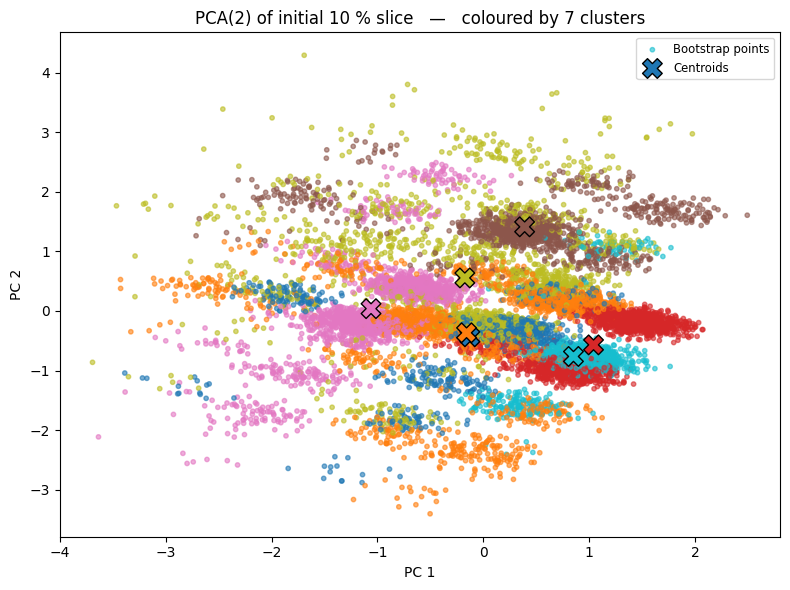

In [85]:
# project whitened data down to 2-D for plotting
pca_vis = PCA(n_components=2, random_state=SEED_TORCH)
X_2d    = pca_vis.fit_transform(X_wht)
cent_2d = pca_vis.transform(kmeans.cluster_centers_)   # (n_experts, 2)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels, cmap="tab10", s=10, alpha=0.6,
    label="Bootstrap points"
)
plt.scatter(
    cent_2d[:, 0], cent_2d[:, 1],
    c=range(n_experts), cmap="tab10",
    marker="X", s=200, edgecolor="k",
    label="Centroids"
)
plt.title(f"PCA(2) of initial 10 % slice   —   coloured by {n_experts} clusters")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="best", fontsize="small", frameon=True)
plt.tight_layout()
plt.show()

In [86]:
# ────────────────────────────────────────────────────────────────────────────
#  STAGE 1  – TRAIN N EXPERTS
# ────────────────────────────────────────────────────────────────────────────

n_experts = best_k

exp_train_sz       = int(len(expert_block)  * TRAIN_RATIO)
exp_train, exp_val = expert_block[:exp_train_sz], expert_block[exp_train_sz:]

experts   = {cid: tree.HoeffdingTreeClassifier() for cid in range(n_experts)}
exp_val_acc = {cid: metrics.Accuracy()           for cid in range(n_experts)}

for x_dict, y_true in exp_train:
    # 1) Raw → (1×24) → Standardize → Whiten → (1×24)
    x_raw   = d2v(x_dict).reshape(1, -1)       
    x_std   = scaler.transform(x_raw)          
    x_wht   = pca.transform(x_std)             

    # 2) Which cluster does it fall into?
    cluster_id = int(kmeans.predict(x_wht)[0])

    # 3) Train expert[cluster_id] to predict the actual class y_true
    experts[cluster_id].learn_one(x_dict, y_true)

for x_dict, y_true in exp_val:
    x_raw   = d2v(x_dict).reshape(1, -1)
    x_std   = scaler.transform(x_raw)
    x_wht   = pca.transform(x_std)
    cluster_id = int(kmeans.predict(x_wht)[0])

    y_pred_class = experts[cluster_id].predict_one(x_dict)
    exp_val_acc[cluster_id].update(y_true, y_pred_class)

print("\n── EXPERT VALIDATION ACCURACIES (first 50%) ─────────────")
for i in range(n_experts):
    # It is possible that cluster_i never appears in exp_val; in that case
    # exp_val_acc[i].get() will still be 0.0. We can guard against printing 0.0
    # if we also check how many val-samples fell into that cluster (counts).
    print(f" Expert {i:2d}: {exp_val_acc[i].get():.4f}")
print("")




── EXPERT VALIDATION ACCURACIES (first 50%) ─────────────
 Expert  0: 0.7427
 Expert  1: 0.7444
 Expert  2: 0.7805
 Expert  3: 0.6603
 Expert  4: 0.7720
 Expert  5: 0.7779
 Expert  6: 0.6514



In [87]:

# ────────────────────────────────────────────────────────────────────────────
#  STAGE 2  – BUILD ROUTER TRAIN SET
# ────────────────────────────────────────────────────────────────────────────

router_block = stream[half:]

rtr_train_sz       = int(len(router_block)  * TRAIN_RATIO)
rtr_train, rtr_val = router_block[:rtr_train_sz], router_block[rtr_train_sz:]

router_X, router_y = [], []


print("── SPLITS ───────────────────────────────────────────")
print(f" Total samples         : {TOTAL_SAMPLES:,}")
print(f" Expert  train / val   : {len(exp_train):,} / {len(exp_val):,}")
print(f" Router  train / val   : {len(rtr_train):,} / {len(rtr_val):,}")

for x_dict, y_true in rtr_train:
    # 1) Ask each expert to predict a class
    correct_ids = [
        i for i, e in experts.items()
        if e.predict_one(x_dict) == y_true        # “expert_i got the label right?”
    ]
    if not correct_ids:
        continue

    # 2) Use the first correct expert as the router’s target label
    router_X.append(d2v(x_dict))
    router_y.append(correct_ids[0])

router_X = np.stack(router_X)
router_y = np.array(router_y, dtype=np.int64)
print(f"Router-train usable samples            : {len(router_y):,}")

# ────────────────────────────────────────────────────────────────────────────
#  ROUTER MLP
# ────────────────────────────────────────────────────────────────────────────
class TorchDS(Dataset):
    def __init__(self,X,y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
    def __len__(self):  return len(self.X)
    def __getitem__(self,i): return self.X[i], self.y[i]

train_dl = DataLoader(TorchDS(router_X, router_y), batch_size=BATCH, shuffle=True)

class RouterMLP(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, hidden=128, out_dim=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,hidden), nn.SiLU(),
            nn.Linear(hidden,hidden), nn.SiLU(),
            nn.Linear(hidden,out_dim)
        )
    def forward(self,x): return self.net(x)

router = RouterMLP(out_dim=n_experts)
opt    = torch.optim.Adam(router.parameters(), lr=LR)
ce     = nn.CrossEntropyLoss()
print("\n── ROUTER TRAINING ACC (Second 50 %) ──────────────")
router.train()
for epoch in range(1, EPOCHS+1):
    running = 0.0
    for xb,yb in train_dl:
        opt.zero_grad()
        loss = ce(router(xb), yb)
        loss.backward(); opt.step()
        running += loss.item()*len(xb)
    print(f"Epoch {epoch}/{EPOCHS} | router-train CE: {running/len(train_dl.dataset):.4f}")

# ────────────────────────────────────────────────────────────────────────────
#  FINAL EVALUATION ON router-val
# ────────────────────────────────────────────────────────────────────────────
router.eval()
pipeline_acc = metrics.Accuracy()

with torch.no_grad():
    for x_dict, y_true in rtr_val:
        logits = router(torch.tensor(d2v(x_dict))).softmax(dim=0)
        eid    = int(torch.argmax(logits).item())
        # Now expert[eid] actually predicts a class label (0..9):
        y_pred = experts[eid].predict_one(x_dict)
        # If the chosen expert’s prediction matches y_true, pipeline is correct; else “−1”
        final  = y_pred if y_pred == y_true else -1
        pipeline_acc.update(y_true, final)

print(f"\n🏁  Pipeline accuracy on router-val slice: {pipeline_acc.get():.4f}")

── SPLITS ───────────────────────────────────────────
 Total samples         : 100,000
 Expert  train / val   : 32,000 / 8,000
 Router  train / val   : 40,000 / 10,000
Router-train usable samples            : 36,569

── ROUTER TRAINING ACC (Second 50 %) ──────────────
Epoch 1/5 | router-train CE: 0.9584
Epoch 2/5 | router-train CE: 0.7174
Epoch 3/5 | router-train CE: 0.6204
Epoch 4/5 | router-train CE: 0.5635
Epoch 5/5 | router-train CE: 0.5400

🏁  Pipeline accuracy on router-val slice: 0.7630
